https://arxiv.org/ftp/arxiv/papers/1305/1305.6143.pdf

In [1]:
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import regex as re
import numpy as np

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
def clean_text_for_language_model(text, remove_users=True, remove_urls=True, remove_numbers=True):
    """
    Cleans text for deep learning language models, applies pre tokenization

    :param text: Str, text string

    :return: cleaned string
    """

    re_repetition = re.compile(r'(\S)(\1{3,})') #repetition of multiple non-whitespace characters
    re_word_repetition = re.compile(r'(\b\w+\W+)(\1{3,})') #repetition of multiple words

    s = text
    s = re_repetition.sub(replace_repeated_character, s)
    s = re_word_repetition.sub(replace_repeated_word, s)
    s = lower_and_add_toks_for_case(s)
    s = add_spaces_to_hashtags_and_slashes(s)
    s = remove_multiple_whitespace_from_string(s)
    s = add_start_of_doc_tokens(s)
    s = replace_repeated_punc(s)
    if remove_numbers:
        s = replace_numbers(s)
    if remove_users:
        s = extract_mentioned_users(s,
                                    remove_users=False,
                                    replace_with_token=True,
                                    token_to_replace='[USER]')[0]
    if remove_urls:
        s = extract_urls(s,
                         remove_urls=False,
                         replace_with_token=True,
                         token_to_replace='[URL]')[0]
    return s


def replace_repeated_character(m):
    """
    The expression to sub for repeated letters

    :param m: the match of the regex

    :return: substituted string
    """
    TK_REP = '_tk_rep_char_'
    c, cc = m.groups()
    return f' {TK_REP} {len(cc)+1} {c} '


def replace_repeated_word(m):
    """
    The expression to sub for repeated words

    :param m: the match of the regex

    :return: substituted string
    """
    TK_WREP = '_tk_rep_word_'
    c, cc = m.groups()
    return f' {TK_WREP} {len(cc.split())+1} {c} '


def replace_repeated_punc(s):
    """
    Replace repeated punctuation and newline characters

    :param s: text string

    :return: modified text string
    """
    s = re.sub(r'([^\w\d\s]|\n)(\s\1)+', r'_multi_punc_ \1', s)
    return s


def remove_multiple_whitespace_from_string(s):
    s = re.sub(' {2,}', ' ', s)
    return s


def add_spaces_to_hashtags_and_slashes(s):
    s = re.sub(r'([/#])', r' \1 ', s)
    return s


def add_start_of_doc_tokens(s):
    TOK_DOC, TOK_SEC = '_tk_doc_', '_tk_section_'

    for size, section_start in re.findall(r'\n\s((?:=\s)*=)\s([^=]+)\s\1\s\n', s):
        if size == '=':
            token = TOK_DOC
        else:
            token = TOK_SEC

        s = re.sub(re.escape(size + ' ' + section_start + ' ' + size), token + ' ' + section_start + '.', s)

    return s


def lower_and_add_toks_for_case(s):
    TOK_UP, TOK_SENT, TOK_MIX = ' _tk_up_ ', ' _tk_st_ ', ' _tk_mx_ '
    res = []
    prev = '.'
    re_word = re.compile('\w')
    re_nonsp = re.compile('\S')
    for token in re.findall(r'\w+|\W+', s):
        if token.isupper() and len(token) > 2:
            res += [TOK_UP, token.lower()]
        else:
            res += [token.lower()]
    return ''.join(res)


def replace_numbers(s):
    TOK_NUM = '_number_'

    s = re.sub(r'[0-9]+', TOK_NUM, s)

    return s


def fixup(s):
    re1 = re.compile(r'  +')
    s = s.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(s))


def tokenizer_word(text_string,
                   keep_phrases=False,
                   tokenize_punc=False,
                   split_clitics=False,
                   keep_preceeding_space=False):
    """
    Tokenizer that tokenizes a string of text on spaces and new lines (regardless of however many of each.)

    :param text_string: Python string object to be tokenized.
    :param keep_phrases: Booalean will not split "quoted" text
    :param tokenize_punc: Boolean, if true will tokenize punctuation so "hello," becomes ["hello", ","]
    :param split_clitics: Boolean, if true will split tokens such as "I'm" into [I, 'm], must be tokenizing punctuation

    :return: Array of strings, each is a word
    """

    text_string = str(text_string)

    if keep_phrases:
        tokens = shlex.split(text_string.replace('\n', ' ').replace('/', ' '))
    elif tokenize_punc:
        if split_clitics:
            if keep_preceeding_space:
                tokens = regex.findall(
                    r"(?<!\s)'[\w]*"  # an apostrophe and potentially some other charaters, that come after non-whitespace
                    "|\s?'"  # an apostrophe, preceeded by whitespace
                    "|\s?[\w]+"  # one or more word characters
                    "|\s?[.,!?\-;=\n]"  # any single character of [.,!?\-;=\n]
                    "| \X"
                    "|\X"
                    , text_string, re.UNICODE)
            else:
                tokens = re.findall(r"(?<!\s)'[\w]*|(?<=\s)'|[\w]+|[.,!?\-;=\n]", text_string, re.UNICODE)
        else:
            tokens = re.findall(r"[\w']+|[.,!?\-;=\n]", text_string)
    else:
        tokens = text_string.replace('\n', ' ').replace('/', ' ').split()

    return tokens


def extract_mentioned_users(text_string,
                            remove_users=False,
                            replace_with_token=True,
                            token_to_replace='[USER]'):
    """
    Extracts mentioned_users from a text_string

    :param text_string: String of text you wish to extract mentioned_users from
    :param remove_users: Boolean, if True it will remove the mentioned_users from the text_string
    :param replace_with_token: Boolean, replace the users in the original string with a marker token
    :param token_to_replace: Str, the token to replace the user

    :return: text_sting: Sting as input but with mentioned_users removed if specified
    :return: mentioned_users: List of unique mentioned_users in the text_string
    """

    if text_string is np.nan:
        text_string = ''

    mentioned_users = list(set(re.findall(r"@\w+", text_string)))

    if replace_with_token:
        text_string = re.sub(r"@\w+",
                             token_to_replace,
                             text_string)

    if remove_users and not replace_with_token:
        text_string = re.sub(r"@\w+",
                             '',
                             text_string)

    return text_string, mentioned_users


def extract_urls(text_string,
                 remove_urls=False,
                 replace_with_token=True,
                 token_to_replace='[URL]'):
    """
    Extracts url from a text_string

    :param text_string: String of text you wish to extract url from
    :param remove_urls: Boolean, if True it will remove the url from the text_string
    :param replace_with_token: Boolean, replace the urls in the original string with a marker token
    :param token_to_replace: Str, the token to replace the url

    :return: text_sting: Sting as input but with urls removed if specified
    :return: urls: List of unique urls in the text_string
    """

    if text_string is np.nan:
        text_string = ''

    urls = list(set(re.findall(r"(?:http|ftp|https)://[\w_-]+(?:\.[\w_-]+)+(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?",
                               text_string)))

    if replace_with_token:
        text_string = re.sub(r"(?:http|ftp|https)://[\w_-]+(?:\.[\w_-]+)"
                             r"+(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?",
                             token_to_replace,
                             text_string)

    if remove_urls and not replace_with_token:
        text_string = re.sub(r"(?:http|ftp|https)://[\w_-]+(?:\.[\w_-]+)"
                             r"+(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?",
                             '',
                             text_string)

    return text_string, urls

def negate_sequence_stem(text, stemmer):
    """
    Detects negations and transforms negated words into "not_" form.
    """
    negation = False
    delims = "?.,!:;"
    result = []
    words = tokenizer_word(text,
                           keep_phrases=False,
                           tokenize_punc=True,
                           split_clitics=False,
                           keep_preceeding_space=False)
    
    for word in words:
        if negation:
            result.append("not_"+word)
            negation = False
        else:
            result.append(word)
        if any(neg in word for neg in frozenset(["not", "n't", "no"])):
            negation = True
            result = result[:-1]
        if any(c in word for c in delims):
            negation = False
    result = stemmer.stem_text(tokens=result)
    return result


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    :param cm: Confusion matrix
    :param classes: Python list of class names
    :param normalize: Boolean to normalize the matrix
    :param title: Title of the graph
    :param cmap: Colour map
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def tokenizer_sentence(text_string):
    """
    Tokenizer that tokenizes a string of text into sentences

    :param text_string: Python string object to be tokenized.
    :return: Array of strings, each is a sentence
    """

    sent_tokenize_list = sent_tokenize(text_string)

    return sent_tokenize_list
    
class Stemmer():

    def __init__(self, language='english'):
        """
        :param language: String representing the language to be used
        """

        self.stemmer = None

        try:
            self.stemmer = SnowballStemmer(language)
        except ValueError as e:
            print(
                'Invalid language supplied to the stemmer, please choose from: ' + " ".join(SnowballStemmer.languages) +
                '\nOr add a new stemmer to the repository ;)')

    def stem_text(self,
                  text_string=None,
                  tokens=None,
                  pos_tuples=False,
                  check_trailing=True,
                  tokens_to_ignore=None):
        """
        Function that stems a text string using the NLTK snowball stemmer

        :param text_string: Python string object to be tokenized and stemmed
        :param tokens: Python list of strings already tokenized
        :param pos_tuples: Bool, if tokens are a list of pos_tuples set this to true
        :param tokens_to_ignore: List of Str, tokens to avoid cleaning

        :return: String comparable to the input but with all words stemmed.
        """

        if not tokens_to_ignore:
            tokens_to_ignore = ["[USER]", "[HASHTAG]", "[URL]"]

        if tokens is None:
            tokens = []
        if text_string is not None:
            tokens = tokenizer_word(text_string,
                                    tokens_to_ignore=tokens_to_ignore)
            tokens = [self.stemmer.stem(token) if token not in tokens_to_ignore else token for token in tokens]
            stemmed = " ".join(tokens)
        else:
            stemmed = [self.stemmer.stem(token) for token in tokens]

        return stemmed

In [3]:
DATASET = 'amazon_movies'
BALANCED = 'fair_balanced_300'

notebook_dir = pathlib.Path.cwd()
repo_dir = notebook_dir
datasets_dir = repo_dir / "datasets"

df_trn = pd.read_csv(datasets_dir / DATASET / BALANCED / "train.csv")
df_val = pd.read_csv(datasets_dir / DATASET / BALANCED / "validate.csv")

print("Train size:", len(df_trn))
print("Val size:", len(df_val))

Train size: 900
Val size: 15000


In [4]:
df_trn['text'] = df_trn['text'].apply(lambda e: clean_text_for_language_model(e, 
                                                                              remove_users=True, 
                                                                              remove_urls=True, 
                                                                              remove_numbers=True))
df_val['text'] = df_val['text'].apply(lambda e: clean_text_for_language_model(e, 
                                                                              remove_users=True, 
                                                                              remove_urls=True, 
                                                                              remove_numbers=True))

In [5]:
df_trn['text'].sample(n=10)

836    i am not out to convince anybody of anything.....
818    unsure why this got so much hype(then again,im...
574    i'm going to stand out here, but i really didn...
175    these two movies are awesome. i had only seen ...
750    after all the media attention and box office, ...
150    polish filmaker polanski shows the truth in hi...
795    i think people need to rethink their loyalty t...
180    was a good movie. makes you think but is a wei...
770     _tk_up_ plot _tk_up_ spoiler _tk_up_ alert! g...
392    the plot does take a back seat in this film, d...
Name: text, dtype: object

In [6]:
def negate_sequence(text):
    """
    Detects negations and transforms negated words into "not_" form.
    """
    negation = False
    delims = "?.,!:;"
    result = []
    words = tokenizer_word(text,
                           keep_phrases=False,
                           tokenize_punc=True,
                           split_clitics=False,
                           keep_preceeding_space=False)
    for word in words:
        if negation:
            result.append("not_"+word)
            negation = False
        else:
            result.append(word)
        if any(neg in word for neg in frozenset(["not", "n't", "no"])):
            negation = True
            result = result[:-1]
        if any(c in word for c in delims):
            negation = False
    return result

print(negate_sequence("i love my dog he's great"))
print(negate_sequence("i don't love my dog he's not great"))

['i', 'love', 'my', 'dog', "he's", 'great']
['i', 'not_love', 'my', 'dog', "he's", 'not_great']


In [7]:
import itertools
import numpy as np
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    :param cm: Confusion matrix
    :param classes: Python list of class names
    :param normalize: Boolean to normalize the matrix
    :param title: Title of the graph
    :param cmap: Colour map
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Original Naive Bayes with Laplacian Smoothing

In [8]:
tier = int(BALANCED.split('_')[-1])
tier

300

In [9]:
cv = CountVectorizer(stop_words=None, 
                     ngram_range=(1,1),
                     max_features=30*tier,
                     tokenizer=lambda e: tokenizer_word(e, 
                                                        keep_phrases=False,
                                                        tokenize_punc=True,
                                                        split_clitics=False,
                                                        keep_preceeding_space=False))

cv_data_trn = cv.fit_transform(df_trn["text"])
cv_data_val = cv.transform(df_val["text"])

In [10]:
model = MultinomialNB(alpha=1.0, 
                      fit_prior=True, 
                      class_prior=None)

model.fit(cv_data_trn, df_trn['label'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Confusion matrix, without normalization
[[3206 1391  403]
 [1680 2392  928]
 [1202 1801 1997]]


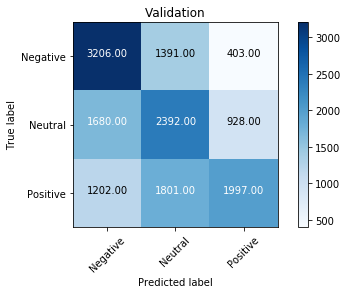

f1 score 0.5063333333333333


In [11]:
preds = model.predict(cv_data_val)
cm_test = confusion_matrix(y_true=df_val["label"], y_pred=preds)
plot_confusion_matrix(cm_test,
                      ['Negative', 'Neutral', 'Positive'],
                      normalize=False,
                      title='Validation')
print("f1 score", f1_score(df_val["label"], preds, average="micro"))

# Handling Negation

In [120]:
cv = CountVectorizer(stop_words=None, 
                     ngram_range=(1,1),
                     max_features=30*tier,
                     tokenizer=lambda e: negate_sequence(e))

cv_data_trn = cv.fit_transform(df_trn["text"])
cv_data_val = cv.transform(df_val["text"])

In [121]:
model = MultinomialNB(alpha=1.0, 
                      fit_prior=True, 
                      class_prior=None)

model.fit(cv_data_trn, df_trn['label'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Confusion matrix, without normalization
[[3161 1133  706]
 [1673 1916 1411]
 [1137 1191 2672]]


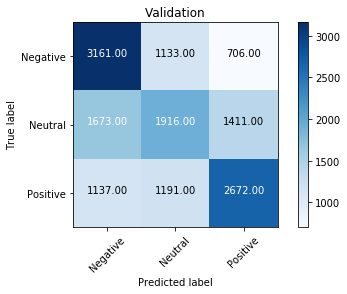

f1 score 0.5166


In [122]:
preds = model.predict(cv_data_val)
cm_test = confusion_matrix(y_true=df_val["label"], y_pred=preds)
plot_confusion_matrix(cm_test,
                      ['Negative', 'Neutral', 'Positive'],
                      normalize=False,
                      title='Validation')
print("f1 score", f1_score(df_val["label"], preds, average="micro"))

# Bernoulli

In [126]:
cv = CountVectorizer(stop_words=None, 
                     ngram_range=(1,1),
                     max_features=30*tier,
                     tokenizer=lambda e: negate_sequence(e),
                     binary=True)

cv_data_trn = cv.fit_transform(df_trn["text"])
cv_data_val = cv.transform(df_val["text"])

In [127]:
model = MultinomialNB(alpha=1.0, 
                      fit_prior=True, 
                      class_prior=None)

model.fit(cv_data_trn, df_trn['label'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Confusion matrix, without normalization
[[3058 1169  773]
 [1454 2104 1442]
 [ 746 1213 3041]]


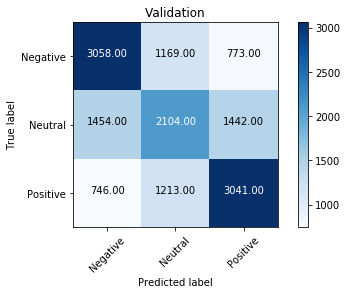

f1 score 0.5468666666666666


In [128]:
preds = model.predict(cv_data_val)
cm_test = confusion_matrix(y_true=df_val["label"], y_pred=preds)
plot_confusion_matrix(cm_test,
                      ['Negative', 'Neutral', 'Positive'],
                      normalize=False,
                      title='Validation')
print("f1 score", f1_score(df_val["label"], preds, average="micro"))

# Bigrams and Trigrams

In [132]:
cv = CountVectorizer(stop_words=None, 
                     ngram_range=(1,3),
                     max_features=30*tier,
                     tokenizer=lambda e: negate_sequence(e),
                     binary=True)

cv_data_trn = cv.fit_transform(df_trn["text"])
cv_data_val = cv.transform(df_val["text"])

In [133]:
model = MultinomialNB(alpha=1.0, 
                      fit_prior=True, 
                      class_prior=None)

model.fit(cv_data_trn, df_trn['label'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Confusion matrix, without normalization
[[3173 1291  536]
 [1383 2488 1129]
 [ 822 1531 2647]]


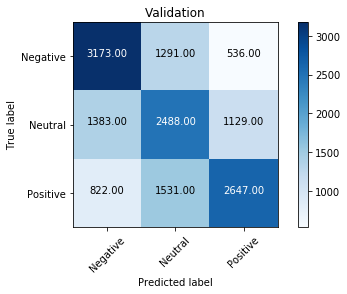

f1 score 0.5538666666666666


In [134]:
preds = model.predict(cv_data_val)
cm_test = confusion_matrix(y_true=df_val["label"], y_pred=preds)
plot_confusion_matrix(cm_test,
                      ['Negative', 'Neutral', 'Positive'],
                      normalize=False,
                      title='Validation')
print("f1 score", f1_score(df_val["label"], preds, average="micro"))

# Stemming

In [78]:
stemmer = Stemmer()

def negate_sequence_stem(text, stemmer):
    """
    Detects negations and transforms negated words into "not_" form.
    """
    negation = False
    delims = "?.,!:;"
    result = []
    words = tokenizer_word(text,
                           keep_phrases=False,
                           tokenize_punc=True,
                           split_clitics=False,
                           keep_preceeding_space=False)
    
    for word in words:
        if negation:
            result.append("not_"+word)
            negation = False
        else:
            result.append(word)
        if any(neg in word for neg in frozenset(["not", "n't", "no"])):
            negation = True
            result = result[:-1]
        if any(c in word for c in delims):
            negation = False
    result = stemmer.stem_text(tokens=result)
    return result

print(negate_sequence_stem("i was hoping this wouldn't be over quickly", stemmer))
print(negate_sequence_stem("can't we all just be friends?", stemmer))

['i', 'was', 'hope', 'this', 'not_b', 'over', 'quick']
['not_w', 'all', 'just', 'be', 'friend', '?']


In [79]:
cv = CountVectorizer(stop_words=None, 
                     ngram_range=(1,3),
                     max_features=3000,
                     tokenizer=lambda e: negate_sequence_stem(e, stemmer),
                     binary=True)

cv_data_trn = cv.fit_transform(df_trn["text"])
cv_data_val = cv.transform(df_val["text"])

In [80]:
model = MultinomialNB(alpha=1.0, 
                      fit_prior=True, 
                      class_prior=None)

model.fit(cv_data_trn, df_trn['label'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Confusion matrix, without normalization
[[2697 1447  856]
 [1407 2310 1283]
 [ 933 1439 2628]]


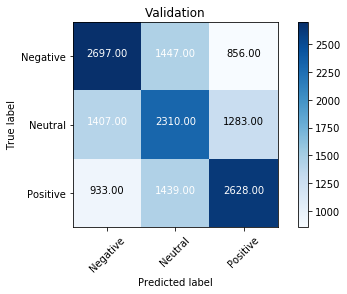

f1 score 0.509


In [81]:
preds = model.predict(cv_data_val)
cm_test = confusion_matrix(y_true=df_val["label"], y_pred=preds)
plot_confusion_matrix(cm_test,
                      ['Negative', 'Neutral', 'Positive'],
                      normalize=False,
                      title='Validation')
print("f1 score", f1_score(df_val["label"], preds, average="micro"))

# Feature Selection 2: POS

In [82]:
from stan_preprocessing.processing.pos_tagging import train_pos_tagger, TagSnippets

train_pos_tagger()

Accuracy  0.9516883298514899
Saving to utils_data/models/pos_taggers/simplified_en.pkl


True

In [83]:
stemmer = Stemmer()
tagger = TagSnippets('simplified_en_pos.pkl')

def negate_sequence_pos(text, stemmer, tagger):
    """
    Detects negations and transforms negated words into "not_" form.
    """
    negation = False
    delims = "?.,!:;"
    result = []
    
    # Do POS
    words = tagger.tag_snippet(text)
    
    #words = tokenizer_word(text,
    #                       keep_phrases=False,
    #                       tokenize_punc=True,
    #                       split_clitics=False,
    #                       keep_preceeding_space=False)
    
    # Deal with negation
    for word, tag in words:
        if negation:
            result.append(("not_"+word, tag))
            negation = False
        else:
            result.append((word, tag))
        if any(neg in word for neg in frozenset(["not", "n't", "no"])):
            negation = True
            result = result[:-1]
        if any(c in word for c in delims):
            negation = False

    # Select features and remove POS tag
    result = [word for word, tag in result if tag in ['VB', 'AV', 'AD', "QL"]]
    
    # Stem resulting            
    result = stemmer.stem_text(tokens=result)
    
    return result

print(negate_sequence_pos("i was really hoping this wouldn't be over quickly", stemmer, tagger))
print(negate_sequence_pos("can't we all just be friends, that's a big house?", stemmer, tagger))

['was', 'realli', 'hope', 'this', 'not_b', 'quick']
['just', 'be', 'that', 'big']


In [87]:
cv = CountVectorizer(stop_words=None, 
                     ngram_range=(1,3),
                     max_features=30000,
                     tokenizer=lambda e: negate_sequence_pos(e, stemmer, tagger),
                     binary=True)

cv_data_trn = cv.fit_transform(df_trn["text"])
cv_data_val = cv.transform(df_val["text"])

In [88]:
model = MultinomialNB(alpha=1.0, 
                    fit_prior=True, 
                    class_prior=None)

model.fit(cv_data_trn, df_trn['label'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Confusion matrix, without normalization
[[2058 1946  996]
 [ 904 2544 1552]
 [ 567 1718 2715]]


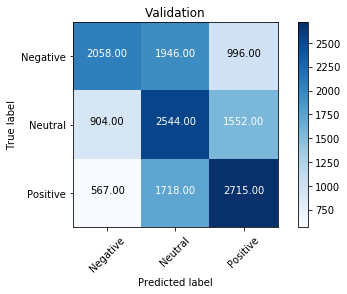

f1 score 0.4878


In [89]:
preds = model.predict(cv_data_val)
cm_test = confusion_matrix(y_true=df_val["label"], y_pred=preds)
plot_confusion_matrix(cm_test,
                      ['Negative', 'Neutral', 'Positive'],
                      normalize=False,
                      title='Validation')
print("f1 score", f1_score(df_val["label"], preds, average="micro"))

# Feature Selection 1: Stopwords

In [ ]:
cv = CountVectorizer(stop_words="english", 
                     ngram_range=(1,3),
                     max_features=300000,
                     tokenizer=lambda e: negate_sequence(e),
                     binary=True)

cv_data_trn = cv.fit_transform(df_trn["text"])
cv_data_val = cv.transform(df_val["text"])

In [ ]:
model = MultinomialNB(alpha=1.0, 
                    fit_prior=True, 
                    class_prior=None)

model.fit(cv_data_trn, df_trn['label'])

In [ ]:
preds = model.predict(cv_data_val)
cm_test = confusion_matrix(y_true=df_val["label"], y_pred=preds)
plot_confusion_matrix(cm_test,
                      [1,2,3,4,5],
                      normalize=False,
                      title='Validation')
print("f1 score", f1_score(df_val["label"], preds, average="micro"))